In [34]:
import xarray as xr
import glob
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.linalg import eig
from scipy.stats import skew, skewtest, percentileofscore

import matplotlib.pyplot as plt
import matplotlib as mpl
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import cmasher as cmr

import sys
sys.path.append("functions/")

import preprocessing
import experiment_settings
import build_model
import metricplots
import allthelinalg
import analysisplots
#import modelandmetrics

import importlib as imp

# pretty plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif']=['Verdana']

params = {"ytick.color": "k",
          "xtick.color": "k",
          "axes.labelcolor": "k",
          "axes.edgecolor": "k"}
plt.rcParams.update(params)

In [35]:
imp.reload(preprocessing)
imp.reload(experiment_settings)
imp.reload(build_model)
imp.reload(metricplots)
imp.reload(allthelinalg)
imp.reload(analysisplots)

<module 'analysisplots' from '/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/functions/analysisplots.py'>

In [36]:
source = "ERSST" # "ERSST" or "HadISST"

In [37]:
modelpath = "models/"
experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead_leaveoneout"
experiment_dict = experiment_settings.get_experiment_settings(experiment_name)
filefront = experiment_dict["filename"]
filename = modelpath + experiment_dict["filename"]
trainvariants = experiment_dict["trainvariants"]
valvariants = experiment_dict["valvariants"]
# testvariants = experiment_dict["testvariants"]
testvariants = np.arange(30)
trainvaltest = [trainvariants,valvariants,testvariants]

modellist = experiment_dict["modellist"]
outbounds = experiment_dict["outbounds"]
seedlist = experiment_dict["seeds"]
run = experiment_dict["run"]
leadtime = experiment_dict["leadtime"]
year1 = 1851+run

lon, lat = preprocessing.outlonxlat(experiment_dict)
lon = np.asarray(lon)
lat = np.asarray(lat)
centre = (outbounds[2]+outbounds[3])/2
projection = ccrs.EqualEarth(central_longitude=centre)
transform = ccrs.PlateCarree()
obsyearvec_ERSST = np.arange(1854+3*run+leadtime,2024,)
obsyearvec_HadISST = np.arange(1870+3*run+leadtime,2024,)
modelyearvec = np.arange(year1+2*run+leadtime,2015)
ntestmems = len(testvariants)

weights = np.meshgrid(lon,lat)[1]
latweights = np.sqrt(np.cos(np.deg2rad(weights)))

In [38]:
data_experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead"
data_experiment_dict = experiment_settings.get_experiment_settings(data_experiment_name)
datafilefront = data_experiment_dict["filename"]
datafile = "processed_data/" + datafilefront + ".npz"

datamat = np.load(datafile)

allinputdata = datamat["allinputdata"]
alloutputdata = datamat["alloutputdata"]

inputdata,inputval,inputtest,outputdata,outputval,outputtest = preprocessing.splitandflatten(
    allinputdata,alloutputdata,trainvaltest,experiment_dict["run"])

inputdata[:, np.isnan(np.mean(inputdata, axis=0))] = 0
inputval[:, np.isnan(np.mean(inputval, axis=0))] = 0
inputtest[:, np.isnan(np.mean(inputtest, axis=0))] = 0

outputstd = np.std(outputdata, axis=0, keepdims=True)
outputdata = outputdata/outputstd
outputval = outputval/outputstd
outputtest = outputtest/outputstd

outputdata[:, np.isnan(np.mean(outputdata, axis=0))] = 0
outputval[:, np.isnan(np.mean(outputval, axis=0))] = 0
outputtest[:, np.isnan(np.mean(outputtest, axis=0))] = 0  

nvars = int(len(valvariants)*len(modellist))
nvariant = len(testvariants)
nmodels = len(modellist)
ntimesteps = int(len(outputtest)/(nvariant*nmodels))

mask = np.copy(outputtest)
mask[mask==0] = np.nan
landmask = ~np.isnan(np.mean(mask,axis=0))

conversion done


In [39]:
inputobs_ERSST,outputobs_ERSST = preprocessing.make_inputoutput_obs(experiment_dict,"ERSST")
inputobs_ERSST,outputobs_ERSST = preprocessing.concatobs(inputobs_ERSST,outputobs_ERSST,outputstd,run)

inputobs_HadISST,outputobs_HadISST = preprocessing.make_inputoutput_obs(experiment_dict,"HadISST")
inputobs_HadISST,outputobs_HadISST = preprocessing.concatobs(inputobs_HadISST,outputobs_HadISST,outputstd,run)

In [40]:
# PDOfile = "processed_data/" + "PDO_" + datafilefront + ".npz"
# saveflag = False

# if saveflag:
#     PDOpatterns_singlemodel = preprocessing.PDO_pattern_singlemodel(experiment_dict)
#     PDOpattern_allmodel = preprocessing.PDO_pattern_allmodels(experiment_dict)
    
#     np.savez(PDOfile,
#               PDOpatterns_singlemodel=PDOpatterns_singlemodel,
#               PDOpattern_allmodel=PDOpattern_allmodel,
#               )
# else:
    
#     PDOmat = np.load(PDOfile)
#     PDOpatterns_singlemodel = PDOmat["PDOpatterns_singlemodel"]
#     PDOpattern_allmodel = PDOmat["PDOpattern_allmodel"]

In [41]:
# thank god i didnt name two functions "reshapengrab" that do two different things! that would be so annoying! 
def reshapengrab_input(mat,imodel,nvariants):
    
    inputshape = mat.shape
    ntimesteps = int(inputshape[0]/(nvariants*nmodels))
    if len(inputshape) == 3:        
        matreshape = np.reshape(mat,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2]))
    else:
        matreshape = np.reshape(mat,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2],inputshape[3]))
    
    allinds = np.arange(nmodels)
    loopinds = allinds[allinds!=imodel]
    
    matgrab = matreshape[loopinds]
    if len(inputshape) == 3:
        shapeout = (ntimesteps*(nmodels-1)*nvariants,inputshape[1],inputshape[2])
    else:
        shapeout = (ntimesteps*(nmodels-1)*nvariants,inputshape[1],inputshape[2],inputshape[3])
    matout = np.reshape(matgrab,shapeout)    

    return matout

def reshapengrab(inputmatrix,ind,nmodels,nvariants):

    # grabs all variants (nvariant) for a single climate model data (ind of nmodel) 
    inputshape = inputmatrix.shape
    ntimesteps = int(inputshape[0]/(nmodels*nvariants))
    if len(inputshape) == 3:        
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2]))
    else:
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2],inputshape[3]))
    
    outputint = intmatrix[ind]
    if len(inputshape) == 3:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2])
    else:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2],inputshape[3])
    outputmatrix = np.reshape(outputint,shapeout)    
    
    return outputmatrix

def weightedMSE(y_pred,y_true,weights):
    err = ((y_pred-y_true)*weights)
    sqerr = err**2
    mse = np.mean(sqerr)
    return mse

In [42]:
bestpatterns = np.empty((len(lat),len(lon),nmodels,len(seedlist)))
obscorr_ERSST = np.empty((nmodels,len(seedlist)))
obscorr_HadISST = np.empty((nmodels,len(seedlist)))
leaveoutcorr = np.empty((nmodels,len(seedlist),ntestmems))

indexmean = np.empty((nmodels,len(seedlist),ntestmems))

valmse = np.empty((nmodels,len(seedlist)))

for imodel,cmodel in enumerate(modellist):

    inputval_short = reshapengrab_input(inputval,imodel,len(valvariants))
    outputdata_short = reshapengrab_input(outputdata,imodel,len(trainvariants))
    outputval_short = reshapengrab_input(outputval,imodel,len(valvariants))
    
    outputstd_new = np.std(outputdata_short,axis=0,keepdims=True)
    
    outputdata_short = outputdata_short/outputstd_new
    outputval_short = outputval_short/outputstd_new
    outputdata_short[:, np.isnan(np.mean(outputdata_short, axis=0))] = 0
    outputval_short[:, np.isnan(np.mean(outputval_short, axis=0))] = 0
    
    title = "leave out " + cmodel

    inputtest_leftout = reshapengrab(inputtest,imodel,nmodels,len(testvariants))
    outputtest_leftout = reshapengrab(outputtest,imodel,nmodels,len(testvariants))
    outputtest_leftout = outputtest_leftout/outputstd_new
    outputtest_leftout[:,np.isnan(np.mean(outputtest_leftout,axis=0))] = 0
    
    for iseed,random_seed in enumerate(seedlist):
    
        fileout = filename + "_seed=" + str(random_seed) + "_NO_" + cmodel +".h5"
            
        tf.random.set_seed(random_seed)
        np.random.seed(random_seed)
        
        full_model = build_model.build_CNN_full(inputval_short, outputval_short, 
                                                        experiment_dict, random_seed)   
        
        full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),)  # optimizer
        
        full_model.load_weights(fileout)
        
        full_model.trainable = False # freeze BN
        
        y_pred_val = full_model.predict(inputval_short)
        y_pred_test_leftout = full_model.predict(inputtest_leftout,verbose=0)

        bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval_short,landmask,latweights)  
        bestpatterns[:,:,imodel,iseed] = bestpattern

        indextimeseries = allthelinalg.index_timeseries(outputtest_leftout,bestpattern,landmask)
        
        for imem in range(ntestmems):
            outputtest_singlemem = outputtest_leftout[ntimesteps*imem:ntimesteps*(imem+1)]
            y_pred_test_singlemem = y_pred_test_leftout[ntimesteps*imem:ntimesteps*(imem+1)]
            
            leaveoutcorr[imodel,iseed,imem],_ = allthelinalg.corr_indextimeseries(
                bestpattern,outputtest_singlemem,y_pred_test_singlemem,landmask)

            indexmean[imodel,iseed,imem] = np.mean(indextimeseries[ntimesteps*imem:ntimesteps*(imem+1)])
            
        
        y_pred_obs_ERSST = full_model.predict(inputobs_ERSST,verbose=0)
        obscorr_ERSST[imodel,iseed],_ = allthelinalg.corr_indextimeseries(
            bestpattern,outputobs_ERSST,y_pred_obs_ERSST,landmask)
        
        y_pred_obs_HadISST = full_model.predict(inputobs_HadISST,verbose=0)
        obscorr_HadISST[imodel,iseed],_ = allthelinalg.corr_indextimeseries(
            bestpattern,outputobs_HadISST,y_pred_obs_HadISST,landmask)

        valmse[imodel,iseed] = weightedMSE(y_pred_val,outputval_short,latweights)

        

/var/folders/84/qffj5kdx3q15s9xdytp7r01r0000gq/T/ipykernel_74817/2265422823.py:18: RuntimeWarning: invalid value encountered in divide
  outputdata_short = outputdata_short/outputstd_new
/var/folders/84/qffj5kdx3q15s9xdytp7r01r0000gq/T/ipykernel_74817/2265422823.py:19: RuntimeWarning: invalid value encountered in divide
  outputval_short = outputval_short/outputstd_new
/var/folders/84/qffj5kdx3q15s9xdytp7r01r0000gq/T/ipykernel_74817/2265422823.py:27: RuntimeWarning: invalid value encountered in divide
  outputtest_leftout = outputtest_leftout/outputstd_new


298/298 [==============================] - 1s 4ms/step


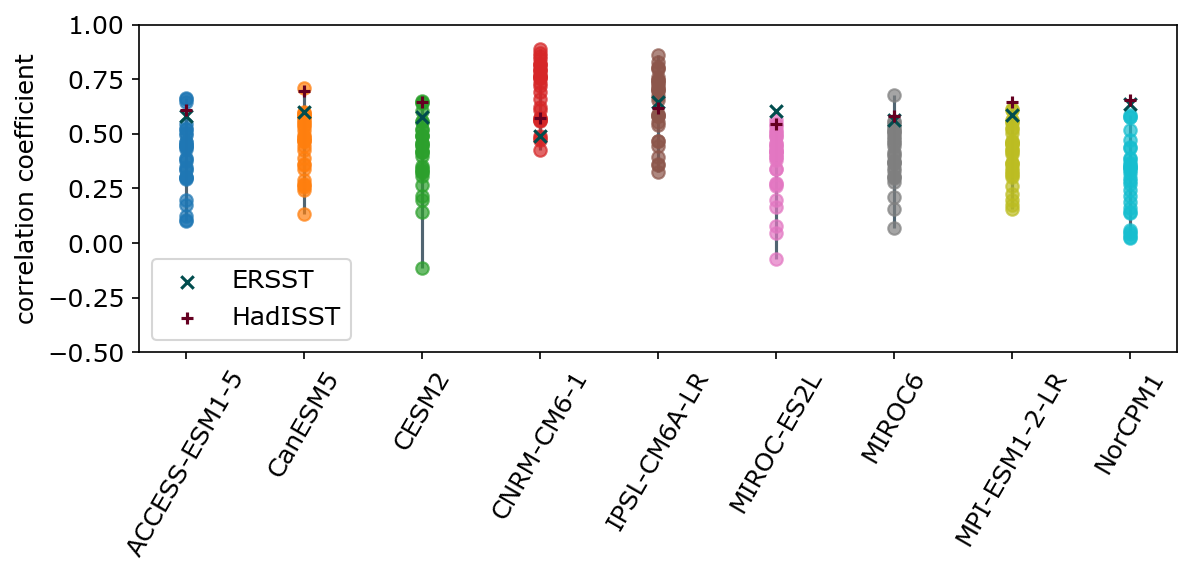

In [43]:
imp.reload(analysisplots)

bestseeds = np.argmin(valmse,axis=1)

leaveoutcorrplot = np.empty((nmodels,ntestmems))
obscorrplot = np.empty((2,nmodels))

for imodel in range(nmodels):
    leaveoutcorrplot[imodel,:] = leaveoutcorr[imodel,bestseeds[imodel],:]
    obscorrplot[0,imodel] = obscorr_ERSST[imodel,bestseeds[imodel]]
    obscorrplot[1,imodel] = obscorr_HadISST[imodel,bestseeds[imodel]]

sourcelist = ["ERSST","HadISST"]

savestr = "figures/prettyscatterplot_leaveoneout.png"
analysisplots.prettyscatterplot_multiobs(leaveoutcorrplot,obscorrplot,modellist,testvariants,"correlation coefficient",sourcelist,savestr)

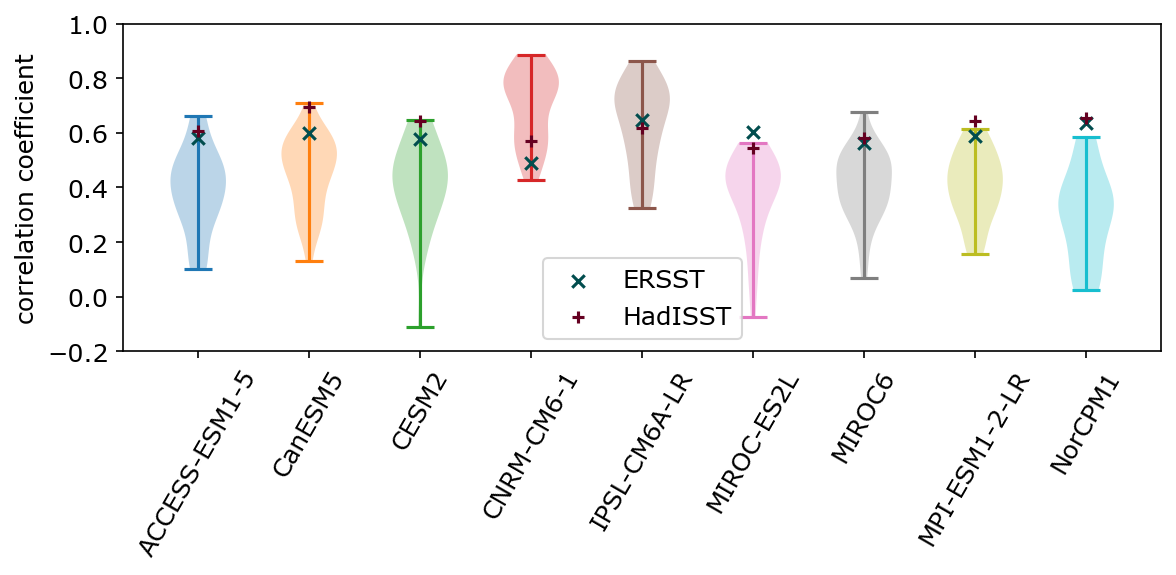

In [44]:
imp.reload(analysisplots)
savestr = "figures/prettyviolinplot_leaveoneout.png"
analysisplots.prettyviolinplot_multiobs(leaveoutcorrplot,obscorrplot,modellist,testvariants,"correlation coefficient",sourcelist,savestr)